In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df = sns.load_dataset('mpg')

In [6]:
X = df[['horsepower']]
y = df['mpg']

# NaNs lead to an error - fit not possible

In [7]:
from sklearn.linear_model import LinearRegression
# fit a linear regression to the mpg-dataset with only horsepower as feature
model = LinearRegression()
model.fit(X, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Fit linear model after imputation (with mean as strategy in SimpleImputer)

In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_imputed = imputer.fit_transform(X)
model.fit(X_imputed, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
print("intercept: {}".format(model.intercept_))
print("slope: {}".format(model.coef_))

intercept: 40.00451551814514
slope: [-0.15784473]


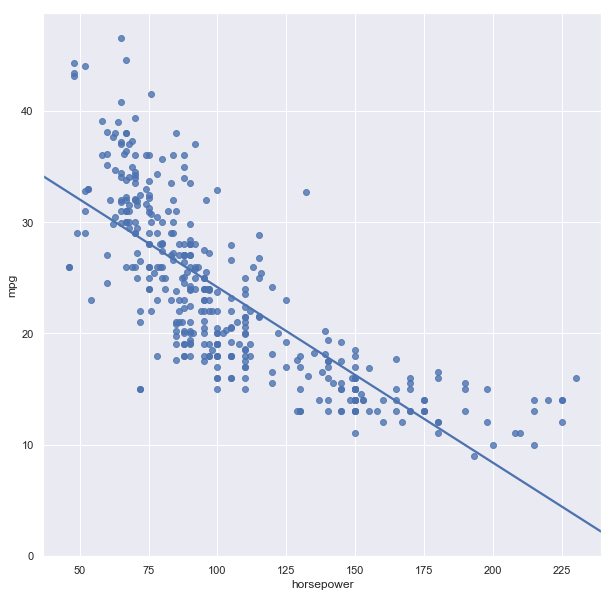

In [11]:
sns.set(rc={'figure.figsize':(10,10)})
sns.regplot(data=df, x='horsepower', y='mpg', ci=None); plt.show()

In [12]:
model.score(X_imputed, y)

0.5951152532609462

# Prediction
## Working Example

In [13]:
df_prediction = pd.DataFrame([120, 170, 200])
model.predict(df_prediction)

array([21.06314752, 13.17091085,  8.43556885])

## Prediction with NaNs leads to an error

In [14]:
df_prediction = pd.DataFrame([120, np.NaN, 200])
model.predict(df_prediction)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Solution: Create pipeline (SimpleImputer + LinearRegression)

In [15]:
from sklearn.pipeline import Pipeline, make_pipeline

pipeline = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

### Predictions with NaNs are now possible

In [16]:
df_prediction = pd.DataFrame([120, np.NaN, 200])
pipeline.predict(df_prediction)

array([21.06314752, 23.51457286,  8.43556885])

In [17]:
# which value is assumed in case of np.NaN?
imputed_horsepowers = df.horsepower.mean()
pipeline.predict([[imputed_horsepowers]])

array([23.51457286])

### We can access the score of the whole pipeline

In [18]:
pipeline.score(X, y)

0.5951152532609462

# Pipeline with standardization

In [1]:
from sklearn.preprocessing import StandardScaler

pipeline2= make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LinearRegression()
)

pipeline2.fit(X, y)
pipeline2.score(X, y)  # scaling does not affect the R^2, it only leads to different intercept/slope

NameError: name 'make_pipeline' is not defined

In [37]:
# pipeline objects contain steps
# please note: make_pipeline generated the names automatically; we can provide names ourselves!
print("steps of pipeline: {}".format(pipeline.named_steps))
print("steps of pipeline2: {}".format(pipeline2.named_steps))

steps of pipeline: {'simpleimputer': SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0), 'linearregression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)}
steps of pipeline2: {'simpleimputer': SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0), 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'linearregression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)}


## standardization only leads to different slope / intercept after fit

In [38]:
# you can access the parameters of, e.g., the linear regression accordingly
reg1 = pipeline.named_steps['linearregression']
print("pipeline - intercept: {} - coefficients: {}".format(reg1.intercept_, reg1.coef_))
reg2 = pipeline2.named_steps['linearregression']
print("pipeline2 - intercept: {} - coefficients: {}".format(reg2.intercept_, reg2.coef_))


pipeline - intercept: 40.00451551814514 - coefficients: [-0.15784473]
pipeline2 - intercept: 23.514572864321607 - coefficients: [-6.02196098]


# Pipeline with Transformation to Standard Normal Distribution

In [39]:
from sklearn.preprocessing import PowerTransformer

pipeline3= make_pipeline(
    SimpleImputer(),
    PowerTransformer(),
    LinearRegression()
)

pipeline3.fit(X, y)
pipeline3.score(X, y) # the transformation to a standard normal distribution improves the score

0.6533178099250534

In [40]:
# predictions of the three pipelines
df_prediction = pd.DataFrame([120, 170, 200])
print(pipeline.predict(df_prediction))
print(pipeline2.predict(df_prediction))
print(pipeline3.predict(df_prediction))

[21.06314752 13.17091085  8.43556885]
[21.06314752 13.17091085  8.43556885]
[19.84060915 13.36590683 10.34000005]


# Visualization

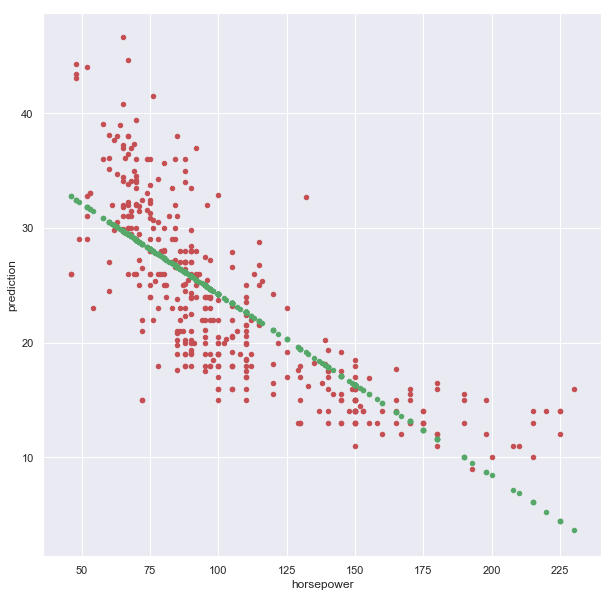

In [42]:
df_viz = df.copy()
df_viz['prediction'] = pipeline.predict(X)
ax1 = df_viz.plot(kind='scatter', x='horsepower', y='mpg', color='r')    
ax2 = df_viz.plot(kind='scatter', x='horsepower', y='prediction', color='g', ax=ax1)
plt.show()